Workload = 50/50

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import ttest_ind
import statsmodels.stats.power as smp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

We load the datasets and extract only the relavant columns that we decided upon in 1st part of this project

In [36]:
df_processes=pd.read_csv("data/processes.csv",sep='\t')
df_connections = pd.read_csv("data/connections.csv", sep='\t')
df_connections=df_connections[df_connections.columns[:8]]
df_processes=df_processes[['imei','ts','mwra','p.android.gm','p.android.settings','p.system','p.android.externalstorage','p.android.documentsui']]
df = df_connections.merge(df_processes, on=['imei', 'ts'], how='outer')
df.head()
df.shape

(15495, 14)

We split the data into 2 dataframes in ratio o 8/2 ( standart data spliting ratios )

In [37]:

df, df_test= train_test_split(df, test_size=0.2, random_state=42)
print(df.shape,df_test.shape)
df_copy=df.copy()

(12396, 14) (3099, 14)


Display the data for better visualization

<Axes: >

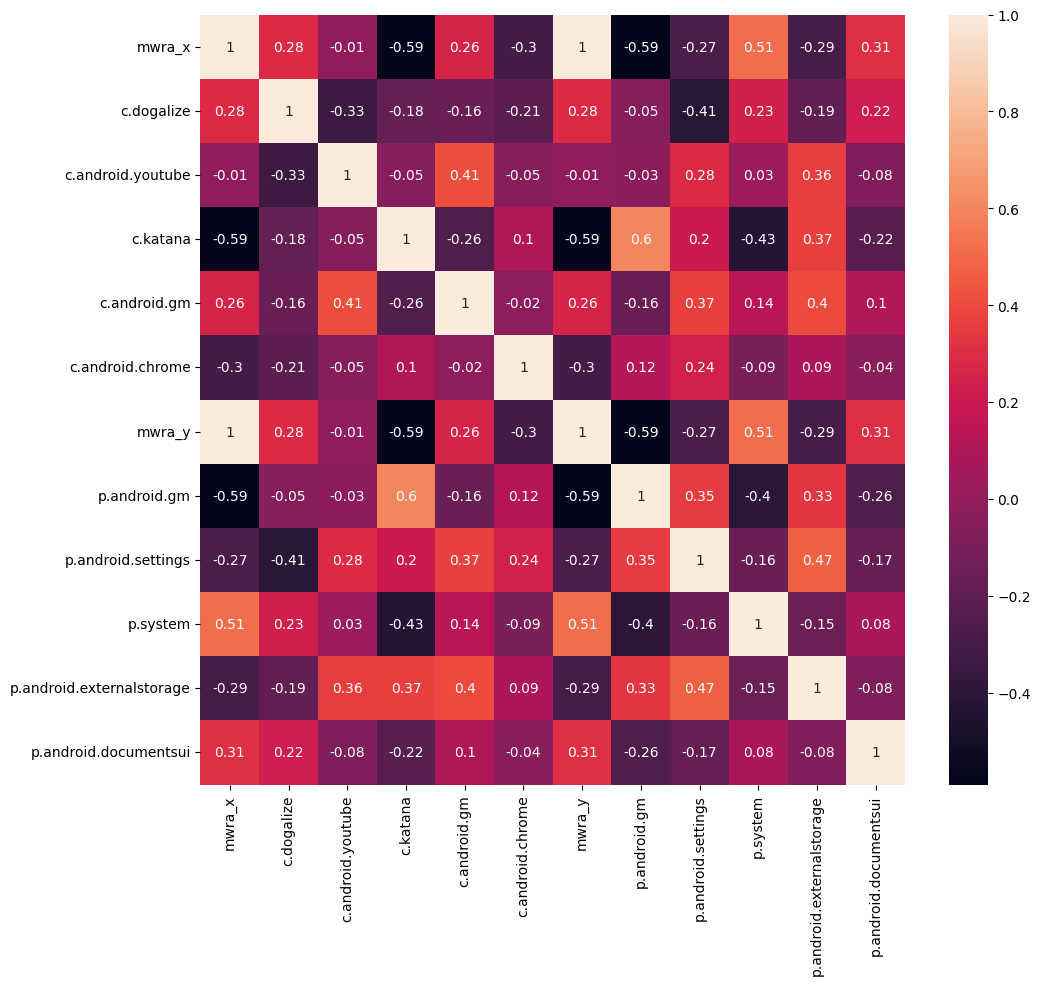

In [38]:
from sklearn.preprocessing import FunctionTransformer
plt.figure(figsize=(25,10))

drop_duplicates_transformer = FunctionTransformer(lambda X: X.drop_duplicates().reset_index(drop=True))
df['ts']=pd.to_datetime(df['ts'])
df = drop_duplicates_transformer.fit_transform(df)

plt.subplot(1,2,1)
sns.heatmap(df.iloc[:,2:].corr().round(decimals=2),annot=True)


for loop will iterate over every column and remove_outlier function will with help of identify_outlier then remove the outlier of said column by replacing it with its nearest quantile

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return (a > upper) | (a < lower)

def remove_outlier(df,column):
    outlier_mask = identify_outliers(df[column])
    lower_bound = df[column].quantile(0.05)
    upper_bound = df[column].quantile(0.95)
    df.loc[outlier_mask, column] = np.where(
        df.loc[outlier_mask, column] < lower_bound,
        lower_bound,
        upper_bound
    )
    return df
#making it into class for pipelline
class RemoveOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for column in self.columns:
            X = remove_outlier(X, column)  
        return X
for column in df.columns:
    df=remove_outlier(df,column)
df.describe()

,ts,imei,mwra_x,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome,mwra_y,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,12009,1.200900e+04,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000
mean,2018-05-10 14:35:38.341244160,3.934129e+18,0.625614,12.154675,12.753828,12.214423,12.090740,11.548909,0.625614,12.212218,13.375461,13.314301,13.407281,13.900475
min,2018-05-05 10:00:00,3.590434e+17,0.000000,4.727800,4.928250,5.127470,4.554110,5.131260,0.000000,5.301570,6.379470,5.382750,6.737060,7.203720
25%,2018-05-08 00:19:00,8.630331e+17,0.000000,10.292320,10.812360,10.416840,10.152280,9.919760,0.000000,10.462010,11.679830,11.333590,11.796200,12.205120
50%,2018-05-10 14:37:00,3.590434e+18,1.000000,12.041480,12.863610,11.999340,11.928020,11.400150,1.000000,12.001740,13.667800,13.343760,13.669880,13.997660
75%,2018-05-13 04:52:00,8.630331e+18,1.000000,14.012800,14.743160,14.032680,13.910750,13.118820,1.000000,13.927170,15.219640,15.305410,15.175440,15.623330
max,2018-05-15 19:17:00,8.630331e+18,1.000000,19.558960,20.560460,19.400820,19.527540,17.911160,1.000000,19.099890,20.431470,21.188940,20.208530,20.749850
std,NaN,3.342042e+18,0.483984,2.597452,2.676013,2.412584,2.715785,2.312196,0.483984,2.399588,2.564004,2.757502,2.427862,2.440906


As can be observed , compared to the first df_connectoins.describe() the max/min values are way less extreme making it better suitable for ML

2.1.C Transforming and Scaling the data

Next we want to Scale the data . 

We decided on using RobustScaler because it uses median and IQR, also because it's less affected by skewness and is very reliable in producing stable scaled output.

Since we were tasked with using 2 scalers we decided on using MinMaxScaler because it can produce pretty much same result as RobustScaler making it more readable for humans and machines.



In here we created scale_data function that takes as arguments the dataframe , high_std_columns and low_std_columns . We didn't know how to choose which data to pick for which scaler that's why we decided to use std as value that decides. columns with std higher than 2.5 will be scaled by RobustScaler and columns with std bigger than 1 but lower than 2.5 will be scaled by MinMaxScaler to value bettwen 0 and 2 . In the function we first save the the mwra column to it's own variable and drop it from main df because it would cause problems in ColumnTransformer and shift the column values around. Next we create ColumnTransformer which has MinMaxScaler and RobustScaler inside of it where MinMaxScaler takes as argument low_std and RobustScaler takes high_std. Pipeline is then created and then the data is passed into the pipeline to scale the data and lastly we add the mwra back inside  --note : I decided to scale both dataframes for pipeline reasons


In [40]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
def scale_data(df, high_std_columns, low_std_columns):
    mwra = df[['imei','ts','mwra_x','mwra_y']]
    df_transformed = df.drop(columns=['mwra_x','ts','imei','mwra_y'])

    # Define transformers for low and high std columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('low_std', MinMaxScaler(feature_range=(-2, 2)), low_std_columns),
            ('high_std', RobustScaler(), high_std_columns)
        ],
        remainder='passthrough'
    )
    
    # Create a pipeline with the ColumnTransformer
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    scaled_data = pipeline.fit_transform(df_transformed)
    scaled_df = pd.DataFrame(scaled_data, columns=df_transformed.columns)
    
    for column in scaled_df.columns:
        min_value = scaled_df[column].min()
        scaled_df[column] += abs(min_value) 
    

    final_df = pd.concat([mwra.reset_index(drop=True), scaled_df.reset_index(drop=True)], axis=1)
    return final_df[df.columns]
class ScaleData(BaseEstimator, TransformerMixin):
    def __init__(self, high_std_columns, low_std_columns):
        self.high_std_columns = high_std_columns
        self.low_std_columns = low_std_columns
    
    def fit(self, X, y=None):
        return self  # No fitting needed for scaling
    
    def transform(self, X, y=None):
        # Use the existing scale_data function to transform the data
        return scale_data(X, self.high_std_columns, self.low_std_columns)
# we devide the tables 
std_devs = df.drop(['ts','imei'],axis=1).std()
high_std_columns = std_devs[std_devs > 2.5].index
low_std_columns = std_devs[(std_devs > 1) & (std_devs <= 2.5)].index
#we save this distribution and use it later for testing data as well
print("columns with std lower than 2.5 = "+low_std_columns)
print("columns with std higher than 2.5 = "+high_std_columns)
scale_transformer_connections = ScaleData(high_std_columns, low_std_columns)
df= scale_transformer_connections.fit_transform(df)




Index(['columns with std lower than 2.5 = c.katana',
       'columns with std lower than 2.5 = c.android.chrome',
       'columns with std lower than 2.5 = p.android.gm',
       'columns with std lower than 2.5 = p.android.externalstorage',
       'columns with std lower than 2.5 = p.android.documentsui'],
      dtype='object')
Index(['columns with std higher than 2.5 = c.dogalize',
       'columns with std higher than 2.5 = c.android.youtube',
       'columns with std higher than 2.5 = c.android.gm',
       'columns with std higher than 2.5 = p.android.settings',
       'columns with std higher than 2.5 = p.system'],
      dtype='object')


As can be observed, the values are all in range -2 to 2 

In [41]:
df.describe()

,ts,imei,mwra_x,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome,mwra_y,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,12009,1.200900e+04,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000
mean,2018-05-10 14:35:38.341244160,3.934129e+18,0.625614,1.986066,2.008670,2.003330,1.980547,1.977467,0.625614,1.996214,1.990836,2.005239,1.976375,1.996956
min,2018-05-05 10:00:00,3.590434e+17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018-05-08 00:19:00,8.630331e+17,0.000000,1.482307,1.498760,1.495962,1.502179,1.476850,0.000000,1.495646,1.496924,1.489481,1.497357,1.498265
50%,2018-05-10 14:37:00,3.590434e+18,1.000000,1.925790,1.962109,1.942315,2.058519,2.006164,1.000000,1.965789,2.018765,1.961945,2.058961,2.004373
75%,2018-05-13 04:52:00,8.630331e+18,1.000000,2.495619,2.500038,2.500478,2.505556,2.486204,1.000000,2.495646,2.496924,2.489481,2.497357,2.498265
max,2018-05-15 19:17:00,8.630331e+18,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000,3.986357,3.976852,3.983916,3.969705,3.979584
std,NaN,3.342042e+18,0.483984,0.676109,0.723698,0.695617,0.720890,0.720768,0.483984,0.698150,0.680781,0.722577,0.724334,0.694267


array([[<Axes: title={'center': 'mwra_x'}>,
        <Axes: title={'center': 'c.dogalize'}>,
        <Axes: title={'center': 'c.android.youtube'}>],
       [<Axes: title={'center': 'c.katana'}>,
        <Axes: title={'center': 'c.android.gm'}>,
        <Axes: title={'center': 'c.android.chrome'}>],
       [<Axes: title={'center': 'mwra_y'}>,
        <Axes: title={'center': 'p.android.gm'}>,
        <Axes: title={'center': 'p.android.settings'}>],
       [<Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>,
        <Axes: title={'center': 'p.android.documentsui'}>]], dtype=object)

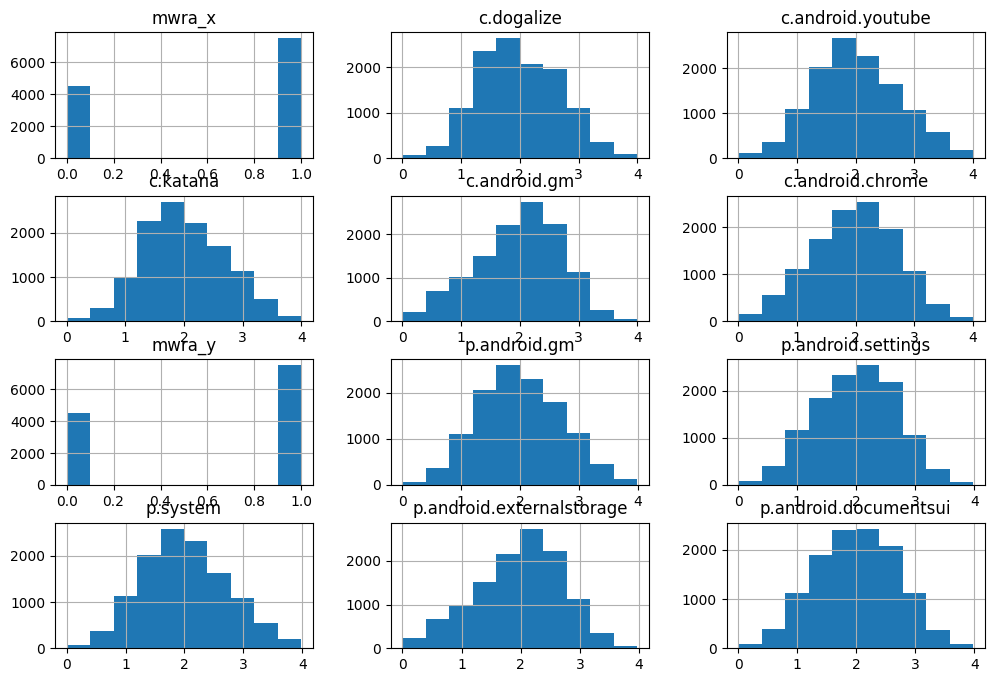

In [42]:
df.hist(column=df.columns[2:],figsize=(12,8))

Next we decided upon using PowerTransformer and QuantileTransformer but first we display data to better observe how the data is changing

In [43]:
df.describe()

,ts,imei,mwra_x,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome,mwra_y,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,12009,1.200900e+04,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000
mean,2018-05-10 14:35:38.341244160,3.934129e+18,0.625614,1.986066,2.008670,2.003330,1.980547,1.977467,0.625614,1.996214,1.990836,2.005239,1.976375,1.996956
min,2018-05-05 10:00:00,3.590434e+17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018-05-08 00:19:00,8.630331e+17,0.000000,1.482307,1.498760,1.495962,1.502179,1.476850,0.000000,1.495646,1.496924,1.489481,1.497357,1.498265
50%,2018-05-10 14:37:00,3.590434e+18,1.000000,1.925790,1.962109,1.942315,2.058519,2.006164,1.000000,1.965789,2.018765,1.961945,2.058961,2.004373
75%,2018-05-13 04:52:00,8.630331e+18,1.000000,2.495619,2.500038,2.500478,2.505556,2.486204,1.000000,2.495646,2.496924,2.489481,2.497357,2.498265
max,2018-05-15 19:17:00,8.630331e+18,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000,3.986357,3.976852,3.983916,3.969705,3.979584
std,NaN,3.342042e+18,0.483984,0.676109,0.723698,0.695617,0.720890,0.720768,0.483984,0.698150,0.680781,0.722577,0.724334,0.694267


We decided to use PowerTransformer or QuantileTransformer for this task because as we were taught , the normal distribution is helpful in more than few aspects hence achieving gausian like distribution was our goal for this Machine Learning project.


Firstly we devided the data in same way as we did with df_connections . Then by creating function we achived abstraction and reusability for future use . In this function we once again save mwra to it's own column and transform the data using PowerTransformer and QuantileTransformer inside Pipeline . Lastly we concat the data and return them in same order as they were given to us (return final_df[df_processes.columns])


array([[<Axes: title={'center': 'mwra_x'}>,
        <Axes: title={'center': 'c.dogalize'}>,
        <Axes: title={'center': 'c.android.youtube'}>],
       [<Axes: title={'center': 'c.katana'}>,
        <Axes: title={'center': 'c.android.gm'}>,
        <Axes: title={'center': 'c.android.chrome'}>],
       [<Axes: title={'center': 'mwra_y'}>,
        <Axes: title={'center': 'p.android.gm'}>,
        <Axes: title={'center': 'p.android.settings'}>],
       [<Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>,
        <Axes: title={'center': 'p.android.documentsui'}>]], dtype=object)

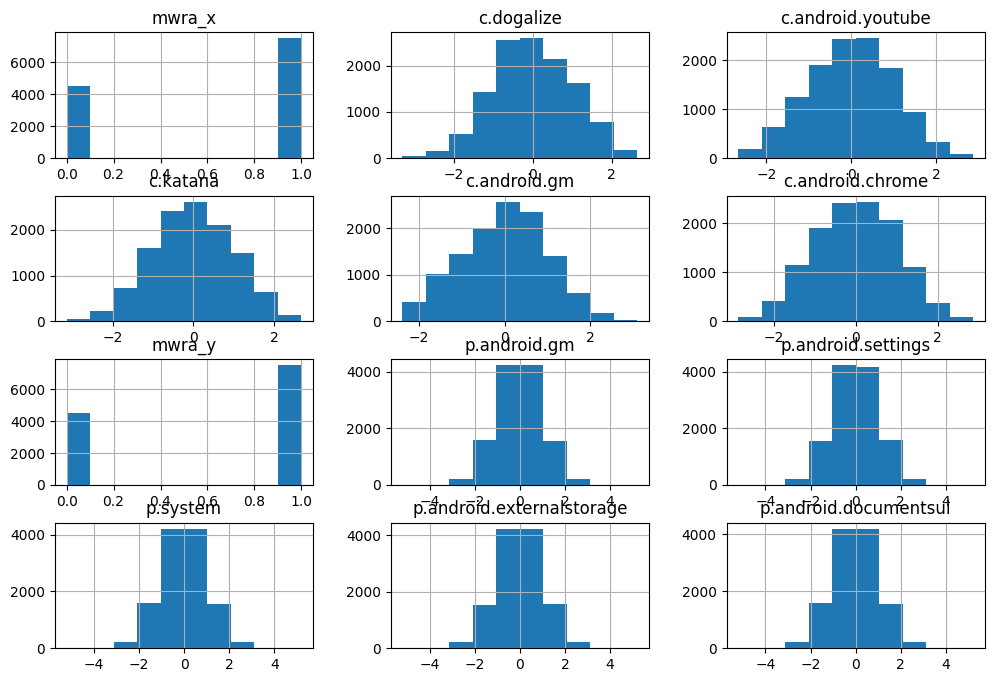

In [44]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer# type: ignore
from sklearn.base import BaseEstimator, TransformerMixin
#we make it into a function for better reusability
def transform_data(df,high_std_columns,low_std_columns):

    mwra = df[['imei','ts','mwra_x','mwra_y']]
    df_transformed = df.drop(columns=['mwra_x','ts','imei','mwra_y'])
    #column transformer for specified Transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('low_std', PowerTransformer(method='yeo-johnson'), low_std_columns),
            ('high_std', QuantileTransformer(output_distribution='normal'), high_std_columns)
        ],
        remainder='passthrough'
    )

    #  Create a pipeline with the ColumnTransformer
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    transformed_data = pipeline.fit_transform(df_transformed)
    transformed_df = pd.DataFrame(transformed_data, columns=df_transformed.columns)# convert the data back to df

    #  add 'mwra' back to the front
    final_df = pd.concat([mwra.reset_index(drop=True), transformed_df.reset_index(drop=True)], axis=1)

    # put them back to their original order
    return final_df[df.columns]
class TransformData(BaseEstimator, TransformerMixin):
    def __init__(self, high_std_columns, low_std_columns):
        self.high_std_columns = high_std_columns
        self.low_std_columns = low_std_columns
    
    def fit(self, X, y=None):
        return self  # No fitting needed for transformation
    
    def transform(self, X, y=None):
        # Use the existing transform_data function to transform the data
        return transform_data(X, self.high_std_columns, self.low_std_columns)
transformer_processes = TransformData(high_std_columns, low_std_columns)

df = transformer_processes.fit_transform(df)

df.hist(column=df.columns[2:],figsize=(12,8))


Clear differences and better , more gausian like results can be observed

2.3 we can easily adjust the testing data using the exact same functions /methods we used on the training data (drop duplicats,remove_outlier,scale_data/transform_data). Pipeline was used in scale_data and transform_data

In [45]:
df_copy.shape

(12396, 14)

In [52]:
    
def create_pipeline(high_std_columns, low_std_columns, outlier_columns):
    return Pipeline(steps=[
        ('drop_duplicates', drop_duplicates_transformer),
        ('remove_outliers', RemoveOutliers(columns=outlier_columns)),
        ('scale_data', ScaleData(high_std_columns=high_std_columns, low_std_columns=low_std_columns)),
        ('transform_data', TransformData(high_std_columns=high_std_columns, low_std_columns=low_std_columns)),
    ])
outlier_columns= df.drop(['ts','imei'],axis=1).columns.tolist()

pipeline = create_pipeline(high_std_columns, low_std_columns, outlier_columns)

df_transformed = pipeline.fit_transform(df_copy)
df_test_transformed = pipeline.transform(df_test)

df_transformed.describe()

,imei,mwra_x,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome,mwra_y,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,1.200900e+04,12009.000000,1.200900e+04,1.200900e+04,1.200900e+04,1.200900e+04,1.200900e+04,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000
mean,3.934129e+18,0.625614,-4.609150e-16,-1.597523e-16,2.982043e-16,-1.218851e-16,-8.135534e-17,0.625614,-0.005725,-0.007511,-0.005019,-0.002130,0.004035
std,3.342042e+18,0.483984,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,0.483984,0.994777,1.000838,1.000709,1.001723,0.999047
min,3.590434e+17,0.000000,-3.310218e+00,-2.662688e+00,-3.151932e+00,-2.389673e+00,-2.867027e+00,0.000000,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,8.630331e+17,0.000000,-7.086047e-01,-7.019335e-01,-7.005123e-01,-7.051925e-01,-7.189977e-01,0.000000,-0.677485,-0.684432,-0.677096,-0.675716,-0.668958
50%,3.590434e+18,1.000000,-4.830102e-02,2.955673e-02,-1.486231e-02,6.454367e-02,9.651701e-03,1.000000,-0.002611,-0.004877,-0.004074,-0.001440,0.005218
75%,8.630331e+18,1.000000,7.319722e-01,7.023481e-01,7.271932e-01,7.078344e-01,7.217480e-01,1.000000,0.665012,0.670650,0.664369,0.673900,0.678696
max,8.630331e+18,1.000000,2.646128e+00,2.870910e+00,2.684928e+00,3.105161e+00,2.862369e+00,1.000000,5.199338,5.199338,5.199338,5.199338,5.199338


In [51]:
df.describe()

ts                            object
imei                           int64
mwra_x                       float64
c.dogalize                   float64
c.android.youtube            float64
c.katana                     float64
c.android.gm                 float64
c.android.chrome             float64
mwra_y                       float64
p.android.gm                 float64
p.android.settings           float64
p.system                     float64
p.android.externalstorage    float64
p.android.documentsui        float64
dtype: object


,ts,imei,mwra_x,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome,mwra_y,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,12009,1.200900e+04,12009.000000,1.200900e+04,1.200900e+04,1.200900e+04,1.200900e+04,1.200900e+04,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000,12009.000000
mean,2018-05-10 14:35:38.341244160,3.934129e+18,0.625614,-4.609150e-16,-1.597523e-16,2.982043e-16,-1.218851e-16,-8.135534e-17,0.625614,-0.005152,0.000642,-0.000311,0.001551,-0.001824
min,2018-05-05 10:00:00,3.590434e+17,0.000000,-3.310218e+00,-2.662688e+00,-3.151932e+00,-2.389673e+00,-2.867027e+00,0.000000,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,2018-05-08 00:19:00,8.630331e+17,0.000000,-7.086047e-01,-7.019335e-01,-7.005123e-01,-7.051925e-01,-7.189977e-01,0.000000,-0.678735,-0.677911,-0.671052,-0.673051,-0.677852
50%,2018-05-10 14:37:00,3.590434e+18,1.000000,-4.830102e-02,2.955673e-02,-1.486231e-02,6.454367e-02,9.651701e-03,1.000000,-0.004078,-0.002658,-0.001354,0.003577,-0.000476
75%,2018-05-13 04:52:00,8.630331e+18,1.000000,7.319722e-01,7.023481e-01,7.271932e-01,7.078344e-01,7.217480e-01,1.000000,0.667506,0.677523,0.673207,0.674558,0.679998
max,2018-05-15 19:17:00,8.630331e+18,1.000000,2.646128e+00,2.870910e+00,2.684928e+00,3.105161e+00,2.862369e+00,1.000000,5.199338,5.199338,5.199338,5.199338,5.199338
std,NaN,3.342042e+18,0.483984,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,1.000042e+00,0.483984,0.999053,1.007508,1.001263,1.002905,1.007858


Pipeline works ! (I think it does ? meowkity !)